In [11]:
# -*- coding: utf-8 -*-
import multiprocessing
import pickle
import time
time.clock= time.time
import sys

from scipy.special import polygamma as pg
from scipy.special import psi as psi

import numpy as np

SMALL_NUMBER = 1e-100

# This is the LDA implementation to use
# K = number of topics
# eta = hyperparameter for topics (i.e. pseudo word counts)
# alpha = initial Dirichlet hyperparameter
# update_alpha = boolean to determine whether or not alpha is updated at each iteration
# word_index is a dictionary storing the position of each feature in numpy arrays
 # word_index is only used in multi-file as it's important that features are always in the same order.
 # In single file it is created internally
class VariationalLDA(object):
    def __init__(self,corpus=None,K = 20,eta=0.1,
        alpha=1,update_alpha=True,word_index=None,normalise = -1,fixed_topics = None,fixed_topics_metadata = None,
        topic_index = None,top_verbose = True):
        self.corpus = corpus
        self.word_index = word_index
        self.normalise = normalise
        #  If the corpus exists, make the word index and the (unused?) word doc matrix
        if not self.corpus == None:
            self.n_docs = len(self.corpus)
            if self.word_index == None:
                self.word_index = self.find_unique_words()
            if top_verbose:
                print ("Object created with {} documents".format(self.n_docs))
            self.n_words = len(self.word_index)
            self.make_doc_index()
            if self.normalise > -1:
                if top_verbose:
                    print ("Normalising intensities")
                #self.normalise_intensities()
        
        self.K = K

        if fixed_topics:
            self.n_fixed_topics = len(fixed_topics)
            self.K += self.n_fixed_topics
        else:
            self.n_fixed_topics = 0


        self.alpha = alpha
        #  If alpha is a single value, make it into a vector
        if type(self.alpha) == int or type(self.alpha) == float:
            self.alpha = self.alpha*np.ones(self.K)
        self.eta = eta # Smoothing parameter for beta
        self.update_alpha = update_alpha
        self.doc_metadata = None
        

        # self.topic_index = topic_index
        # self.topic_metadata = topic_metadata
        self.topic_index = topic_index
        if not self.topic_index:
            self.topic_index = {}
            self.topic_metadata = {}
            topic_pos = 0
            if fixed_topics:
                for topic_name in fixed_topics:
                    self.topic_index[topic_name] = topic_pos
                    #self.topic_metadata[topic_name] = fixed_topics_metadata[topic_name]
                    #self.topic_metadata[topic_name]['type'] = 'fixed'
                    topic_pos += 1
        
            for topic_pos in range(self.n_fixed_topics,self.K):
                topic_name = 'motif_{}'.format(topic_pos)
                #self.topic_index[topic_name] = topic_pos
                #self.topic_metadata[topic_name] = {'name':topic_name,'type':'learnt'}

        if fixed_topics:
            self._add_exact_fixed_topics(fixed_topics)
            

    def _add_exact_fixed_topics(self,fixed_topics):
        # first add any missing words
        #word_pos = max(self.word_index.values())+1

        #for topic,spectrum in fixed_topics.items():
         #   for word in spectrum:
          #      if not word in self.word_index:
           #         self.word_index[word] = word_pos
            #        word_pos += 1
        #self.n_words = len(self.word_index)

        # Now make the fixed rows of beta
        self.beta_matrix = np.zeros((self.K,self.n_words),np.float64) + SMALL_NUMBER
        #self.beta_matrix[0:50,:] = fixed_topics
        for topic_pos,spectrum in fixed_topics.items():
                for word_pos,val in spectrum.items():
                    self.beta_matrix[topic_pos,word_pos] = val
                self.beta_matrix[topic_pos,:] /= self.beta_matrix[topic_pos,:].sum()


    def create_word_index (self,df):
        word_index = {}
        pos = 0
        for word in list(df.T.columns):
            word_index[word] = pos
            pos += 1
        return word_index
   
    def create_doc_index (self,df):
        self.doc_index = {}
        doc_pos = 0
        for doc in list(df.T.index):
            self.doc_index[doc] = doc_pos
            doc_pos += 1
                
    def load_data_sc(self,df):
        print ("Edited")
        self.n_docs = df.T.shape[0]
        self.word_index = self.create_word_index(df)
        self.create_doc_index(df)
        self.n_words = df.T.shape[1]
        self.corpus = df.T.to_dict(orient="index")
        for doc in self.corpus.keys(): 
            self.corpus[doc] = {key:val for key, val in self.corpus[doc].items() if val != 0}
        
 
        
        
   
    # Run the VB inference. Verbose = True means it gives output each iteration
    # initialise = True initialises (i.e. restarts the algorithm)
    # This means we can run the algorithm from where it got to.
    # First time its run, initialise has to be True
    def run_vb(self,n_its = 1,verbose=True,initialise=True):
        if initialise:
            if verbose:
                print ("Initialising")
            self.init_vb()
        if verbose:
            print ("Starting iterations")
        for it in range(n_its):
            start_time = time.clock()
            diff = self.vb_step()
            end_time = time.clock()
            self.its_performed += 1
            estimated_finish = ((end_time - start_time)*(n_its - it)/60.0)
            if verbose:
                print ("Iteration {} (change = {}) ({} seconds, I think I'll finish in {} minutes). Alpha: ({},{})".format(it,diff,end_time - start_time,estimated_finish,self.alpha.min(),self.alpha.max()))

    # D a VB step
    def vb_step(self):
        # Run an e-step
        temp_beta = self.e_step()
        temp_beta += self.eta
        # Do the normalisation in the m step
        if self.n_fixed_topics > 0:
            temp_beta[:self.n_fixed_topics,:] = self.beta_matrix[:self.n_fixed_topics,:]
        temp_beta /= temp_beta.sum(axis=1)[:,None]
        # Compute how much the word probabilities have changed
        total_difference = (np.abs(temp_beta - self.beta_matrix)).sum()
        self.beta_matrix = temp_beta
        # If we're updating alpha, run the alpha update
        if self.update_alpha:
            self.alpha = self.alpha_nr(init_alpha = self.alpha.copy())
        return total_difference
        # self.m_step()

    # Newton-Raphson procedure for updating alpha
    def alpha_nr(self,maxit=20,init_alpha=[]):
        old_alpha = self.alpha.copy()
        try:
            M,K = self.gamma_matrix.shape
            if not len(init_alpha) > 0:
                init_alpha = self.gamma_matrix.mean(axis=0)/K
            alpha = init_alpha.copy()
            alphap = init_alpha.copy()
            g_term = (psi(self.gamma_matrix) - psi(self.gamma_matrix.sum(axis=1))[:,None]).sum(axis=0)
            for it in range(maxit):
                grad = M *(psi(alpha.sum()) - psi(alpha)) + g_term
                H = -M*np.diag(pg(1,alpha)) + M*pg(1,alpha.sum())


                # playing here....
                z = M*pg(1,alpha.sum())
                h = -M*pg(1,alpha)
                c = ((grad/h).sum())/((1.0/z) + (1.0/h).sum())
                alpha_change = (grad - c)/h

                n_bad = (alpha_change > alpha).sum()
                while n_bad > 0:
                    alpha_change/=2.0
                    n_bad = (alpha_change > alpha).sum()

                
                alpha_new = alpha - alpha_change

                pos = np.where(alpha_new <= SMALL_NUMBER)[0]
                alpha_new[pos] = SMALL_NUMBER

                # if (alpha_new < 0).sum() > 0:
                #   init_alpha /= 10.0
                #   return self.alpha_nr(maxit=maxit,init_alpha = init_alpha)

                diff = np.sum(np.abs(alpha-alpha_new))
                alpha = alpha_new
                if diff < 1e-6 and it > 1:
                    return alpha
        except:
            alpha = old_alpha
        return alpha

    # TODO: tidy up and comment this function
    def e_step(self):
        temp_beta = np.zeros((self.K,self.n_words))
        for doc in self.corpus:
            d = self.doc_index[doc]
            temp_gamma = np.zeros(self.K) + self.alpha
            for word in self.corpus[doc]:
                w = self.word_index[word]
                log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T
                # self.phi_matrix[doc][word] = self.beta_matrix[:,w]*np.exp(psi(self.gamma_matrix[d,:])).T
                # for k in range(self.K):
                #   self.phi_matrix[doc][word][k] = self.beta_matrix[k,w]*np.exp(scipy.special.psi(self.gamma_matrix[d,k]))
                log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
                self.phi_matrix[doc][word] = log_phi_matrix/log_phi_matrix.sum()
                # self.phi_matrix[doc][word] /= self.phi_matrix[doc][word].sum()
                temp_gamma += self.phi_matrix[doc][word]*self.corpus[doc][word]
                temp_beta[:,w] += self.phi_matrix[doc][word] * self.corpus[doc][word]
            # self.phi_matrix[d,:,:] = (self.beta_matrix * self.word_matrix[d,:][None,:] * (np.exp(scipy.special.psi(self.gamma_matrix[d,:]))[:,None])).T
            # self.phi_matrix[d,:,:] /= self.phi_matrix[d,:,:].sum(axis=1)[:,None]
            # self.gamma_matrix[d,:] = self.alpha + self.phi_matrix[d,:,:].sum(axis=0)
            self.gamma_matrix[d,:] = temp_gamma
            pos = np.where(self.gamma_matrix[d,:]<SMALL_NUMBER)[0]
            self.gamma_matrix[d,pos] = SMALL_NUMBER
        return temp_beta

    # Function to find the unique words in the corpus and assign them to indices
    def find_unique_words(self):
        word_index = {}
        pos = 0
        for doc in self.corpus:
            for word in self.corpus[doc]:
                if not word in word_index:
                    word_index[word] = pos
                    pos += 1
        print ("Found {} unique words".format(len(word_index)))
        return word_index

    # Pretty sure this matrix is never used
    def make_doc_index(self):
        self.doc_index = {}
        doc_pos = 0
        for doc in self.corpus:
            self.doc_index[doc] = doc_pos
            doc_pos += 1

    # Initialise the VB algorithm
    # TODO: tidy this up
    def init_vb(self):
        # self.gamma_matrix = np.zeros((self.n_docs,self.K),np.float) + 1.0
        # self.phi_matrix = np.zeros((self.n_docs,self.n_words,self.K))
        self.its_performed = 0
        self.phi_matrix = {}
        self.gamma_matrix = np.zeros((self.n_docs,self.K))
        for doc in self.corpus:
            self.phi_matrix[doc] = {}
            for word in self.corpus[doc]:
                self.phi_matrix[doc][word] = np.zeros(self.K)
            d = self.doc_index[doc]
            doc_total = 0.0
            for word in self.corpus[doc]:
                doc_total += self.corpus[doc][word]
            self.gamma_matrix[d,:] = self.alpha + 1.0*doc_total/self.K
        # # Normalise this to sum to 1
        # self.phi_matrix /= self.phi_matrix.sum(axis=2)[:,:,None]

        # Initialise the betas
        if self.n_fixed_topics == 0:
            # self.beta_matrix = np.random.rand(self.K,self.n_words)
            self.beta_matrix = np.zeros((self.K,self.n_words),np.double)
            for k in range(self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words)) 
        else:
            print ("Here")
            for k in range(self.n_fixed_topics,self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words))
        self.beta_matrix /= self.beta_matrix.sum(axis=1)[:,None]

    # Function to return a dictionary with keys equal to documents and values equal to the probability
    # of the requested document (used for visusaling in DESI imaging)
    def get_topic_as_doc_dict(self,topic_id,thresh = 0.001,normalise=False):
        top = {}
        mat = self.gamma_matrix
        if normalise:
            mat = self.get_expect_theta()

        for doc in self.doc_index:
            pos = self.doc_index[doc]
            if mat[pos,topic_id] >= thresh:
                top[doc] = mat[pos,topic_id]
        return top

    # Return a topic as a dictionary over words
    def get_topic_as_dict(self,topic_id):
        top = {}
        for word in self.word_index:
            top[word] = self.beta_matrix[topic_id,self.word_index[word]]
        return top

    # Return the topic probabilities for all documents 
    # Note that self.doc_index maps the document names to their
    # position in this matrix
    def get_expect_theta(self):
        e_theta = self.gamma_matrix.copy()
        e_theta /= e_theta.sum(axis=1)[:,None]
        return e_theta

    def get_beta(self):
        return self.beta_matrix.copy()

    def make_dictionary(self,metadata=None,min_prob_to_keep_beta = 1e-3,
        min_prob_to_keep_phi = 1e-2,min_prob_to_keep_theta = 1e-2,
        filename = None,features = None,compute_overlaps = True):

        if metadata == None:
            if self.doc_metadata == None:
                metadata = {}
                for doc in self.corpus:
                    metadata[doc] = {'name': doc,'parentmass': float(doc.split('_')[0])}
            else:
                metadata = self.doc_metadata

        lda_dict = {}
        lda_dict['corpus'] = self.corpus
        lda_dict['word_index'] = self.word_index
        lda_dict['doc_index'] = self.doc_index
        lda_dict['K'] = self.K
        lda_dict['alpha'] = list(self.alpha)
        lda_dict['beta'] = {}
        lda_dict['doc_metadata'] = metadata
        lda_dict['topic_index'] = self.topic_index
        lda_dict['topic_metadata'] = self.topic_metadata
        
        pure_gamma = []
        for gamma in self.gamma_matrix:
            pure_gamma.append(list(gamma))

        lda_dict['gamma'] = gamma

        if features:
            lda_dict['features'] = features

        # Create the inverse indexes
        wi = []
        for i in self.word_index:
            wi.append((i,self.word_index[i]))
        wi = sorted(wi,key = lambda x: x[1])

        di = []
        for i in self.doc_index:
            di.append((i,self.doc_index[i]))
        di = sorted(di,key=lambda x: x[1])

        ri,i = zip(*wi)
        ri = list(ri)
        di,i = zip(*di)
        di = list(di)

        # make a reverse index for topics
        tp = [(topic,self.topic_index[topic]) for topic in self.topic_index]
        tp = sorted(tp,key = lambda x: x[1])
        reverse,_ = zip(*tp)

        for k in range(self.K):
            pos = np.where(self.beta_matrix[k,:]>min_prob_to_keep_beta)[0]
            motif_name = reverse[k]
            # motif_name = 'motif_{}'.format(k)
            lda_dict['beta'][motif_name] = {}
            for p in pos:
                word_name = ri[p]
                lda_dict['beta'][motif_name][word_name] = self.beta_matrix[k,p]

        eth = self.get_expect_theta()
        lda_dict['theta'] = {}
        for i,t in enumerate(eth):
            doc = di[i]
            lda_dict['theta'][doc] = {}
            pos = np.where(t > min_prob_to_keep_theta)[0]
            for p in pos:
                motif_name = reverse[p]
                # motif_name = 'motif_{}'.format(p)
                lda_dict['theta'][doc][motif_name] = t[p]

        lda_dict['phi'] = {}
        ndocs = 0
        for doc in self.corpus:
            ndocs += 1
            lda_dict['phi'][doc] = {}
            for word in self.corpus[doc]:
                lda_dict['phi'][doc][word] = {}
                pos = np.where(self.phi_matrix[doc][word] >= min_prob_to_keep_phi)[0]
                for p in pos:
                    motif_name = reverse[p]
                    lda_dict['phi'][doc][word][motif_name] = self.phi_matrix[doc][word][p]
            if ndocs % 500 == 0:
                print ("Done {}".format(ndocs))

        if compute_overlaps:
            os = compute_overlap_scores(lda_dict)
            lda_dict['overlap_scores'] = os

        if not filename == None:
            with open(filename,'w') as f:
                pickle.dump(lda_dict,f)

        return lda_dict



In [12]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.patches as mpatches

from scipy import spatial
from scipy.stats import binom
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.spatial.distance import cosine
from itertools import combinations

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)


#returns a re-normalised delta: all new topics set to 0; old ones normalised
def deltaCell(cellID,documentTopicMatrix,oldTopics,allTopics):
    theta = documentTopicMatrix.loc[cellID]
    delta = np.zeros(allTopics)
    totalSum = sum(theta[0:oldTopics])
    delta[0:oldTopics] = theta[0:oldTopics]/totalSum
    return delta 


def calculateProbs(cellID, geneName,totalTopics,oldTopics,doubletsMatrix,topicWordsMatrix,documentTopicMatrix):
    total = 0
    total2 = 0
    n = doubletsMatrix.T[cellID].sum()
    x = doubletsMatrix.T[cellID][geneName]
    delta = deltaCell(cellID,documentTopicMatrix,oldTopics, totalTopics)
    p = topicWordsMatrix[geneName][0:totalTopics].values
    prob = (1-binom.cdf(x, n, p))+binom.pmf(x, n, p)
    total = sum(documentTopicMatrix.T[cellID].values*prob)
    total2 = sum(delta*prob)
    return (total, total2)


def expectedActualPlot(geneName,totalTopics,oldTopics,cellMatrix,topicWordsMatrix,documentTopicMatrix,dpi=120):
    x = []
    y = []
    for i in cellMatrix.index:
        t,t1= calculateProbs(i,geneName,totalTopics,oldTopics,cellMatrix,topicWordsMatrix,documentTopicMatrix)
        x.append(t)
        y.append(t1)
    plt.scatter(x,y)
    plt.title(geneName,fontsize=20)
    plt.xlabel("Probability given all topics",fontsize=15)
    plt.ylabel("Probability given initial topics",fontsize=15)
    plt.tight_layout()
    plt.savefig(geneName+"_prob_plot.png",dpi=dpi)
    
    

def lrtest(llmin, llmax):
    lr = -2 * (np.log(llmin)-np.log(llmax))
    p = stats.chisqprob(lr,30)
    return lr, p


#gene ranking per topic
def ranking_genes (oldTopicNum, newTopicsNum,scLDAObject,geneNames):
    interesting_genes = pd.DataFrame()
    for k in range(oldTopicNum,newTopicsNum):
        genesNeed = []
        in_newT = []
        percentages = []
        for geneName in geneNames:
            in_new = 0
            in_old = 0
            for key in scLDAObject.phi_matrix.keys():
                if geneName in scLDAObject.phi_matrix[key].keys():
                    if scLDAObject.phi_matrix[key][geneName].argmax()==k:
                        in_new+=1
                    else:
                        in_old+=1
            if in_new>0:
                genesNeed.append(geneName)
                in_newT.append(in_new)
                percentages.append(in_new/(in_new+in_old))
        ranked_genes = pd.DataFrame([genesNeed,in_newT,percentages,np.full((len(genesNeed),1),k)])
        ranked_genes = ranked_genes.T
        ranked_genes = ranked_genes.sort_values([2,1],ascending=False)
        interesting_genes = pd.concat([interesting_genes,ranked_genes])
    
    return interesting_genes


def ranking_genes_realData (oldTopicNum, newTopicsNum,scLDAObject,geneNames):
    interesting_genes = pd.DataFrame()
    for k in range(oldTopicNum,newTopicsNum):
        genesNeed = []
        in_newT = []
        percentages = []
        for geneName in geneNames:
            in_new = 0
            in_old = 0
            for key in scLDAObject.phi_matrix.keys():
                if geneName in scLDAObject.phi_matrix[key].keys():
                    if scLDAObject.phi_matrix[key][geneName].argmax()==k:
                        in_new+=1
                    else:
                        in_old+=1
            if in_new>0:
                genesNeed.append(geneName)
                in_newT.append(in_new)
                percentages.append(in_new/(in_new+in_old))
        ranked_genes = pd.DataFrame([genesNeed,in_newT,percentages,np.full((len(genesNeed),1),k)])
        ranked_genes = ranked_genes.T
        ranked_genes = ranked_genes.sort_values([2,1],ascending=False)
        interesting_genes = interesting_genes.append(ranked_genes[ranked_genes[1]>10])
        
    return interesting_genes



def getROCarrays(oldT,newT,interesting_genes,ground_truth,cutOffList):
    p = []
    n = []
    for i in cutOffList:
        pos,neg = rocCurveValues(oldT,newT,interesting_genes, ground_truth,i)
        p.append(len(pos))
        n.append(len(list(set(neg))))
    return p,n
    
    
def rocCurveValues(oldT, newT,interesting_genes,ground_truth,topGenesCutOff):
    positive = []
    negative = []
    for i in range(oldT,newT):
        for k in interesting_genes[interesting_genes[3]==i].sort_values([1],ascending=False)[0:topGenesCutOff][0].values:
            if k in ground_truth and k not in positive: 
                positive.append(k)
            if k not in ground_truth:
                negative.append(k)
    return positive, negative



def computeCosine (LDAModel,topic1, topic2):
    t1 = LDAModel.beta_matrix[topic1]
    t2 = LDAModel.beta_matrix[topic2]
    return 1-cosine(t1,t2)


def averageDistance(LDAModel):
    totalDistance = 0
    nT = LDAModel.beta_matrix.shape[0]
    numTopics = [i for i in range(0,nT)]
    combs = combinations(numTopics,2)
    for i in list(combs):
        totalDistance+=computeCosine(LDAModel,i[0],i[1])
    
    totalDistance = totalDistance/(nT*(nT-1)/2)
    return totalDistance

    
    


    

In [13]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib.transforms import Bbox
#sys.path.append('../code/')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
#from ldaSingleCell import VariationalLDA
#from utilsFuncs import *
import re



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
my_obj = pd.read_csv('Xu_Data_E.csv', header=0, index_col=0)

In [15]:
##Perplexity test for choosing the number of k#######################################
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

# Read the dataset from 'PD.csv'
dataset = my_obj
print("Done reading file")

numTopics = np.arange(2,20)
valsPerplexity = []

for k in numTopics:
    lda = LatentDirichletAllocation(n_components=k, doc_topic_prior=1, topic_word_prior=0.005)
    output = lda.fit_transform(dataset.T)
    perp = lda.perplexity(dataset.T)
    valsPerplexity.append(int(perp))

print("Writing results")
result = pd.DataFrame({'topics': numTopics, 'perplexity': valsPerplexity})



Done reading file
Writing results


<Figure size 800x600 with 0 Axes>

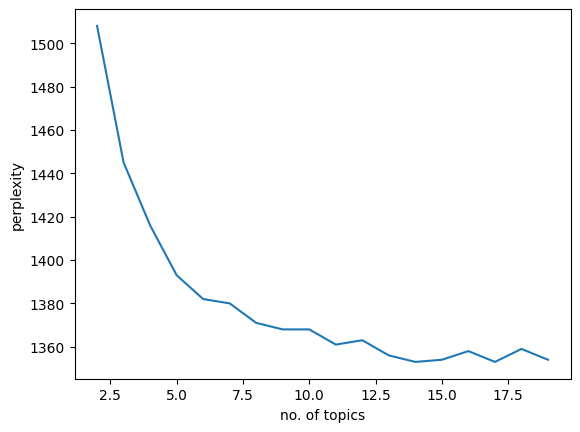

<Figure size 800x600 with 0 Axes>

In [18]:
######plotting the perplexity
import matplotlib.pyplot as plt
perplex= pd.read_csv('Xu_E_perplexities.csv', header=0)
y= perplex['perplexity']
x=perplex['topics']
plt.plot(x, y)
plt.xlabel('no. of topics',fontsize=10)
plt.ylabel('perplexity', fontsize=10)
plt.figure(figsize=(8, 6)) 

In [20]:
Meta= pd.read_csv('Xu_meta_E.csv', header=0, index_col=0)

In [21]:
my_obj.shape

(21784, 1614)

In [22]:
Meta.shape

(1614, 21)

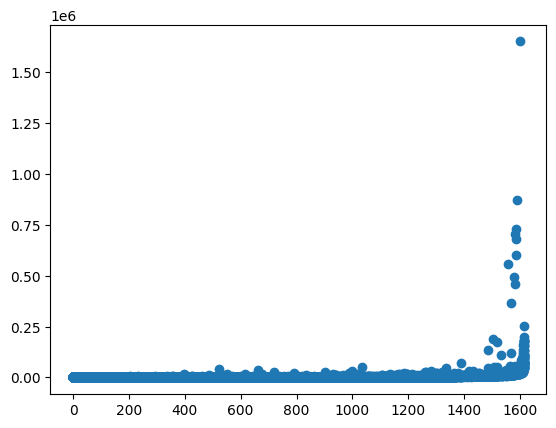

In [23]:
CountsAll= my_obj
plt.plot(CountsAll.astype(bool).sum(axis=1),CountsAll.sum(axis=1),'o')

In [24]:
countsAll= CountsAll
countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]

,Patient2_AAACGAAAGCGATCGA.1,Patient2_AAACGAACAATAAGGT.1,Patient2_AAAGAACGTGTCCGGT.1,Patient2_AAAGAACGTTTCGATG.1,Patient2_AAAGGATAGGGTTGCA.1,Patient2_AAAGGATGTATCACCA.1,Patient2_AAAGGGCTCCCAACTC.1,Patient2_AAAGTCCCACTAACCA.1,Patient2_AAAGTGACATGGCCAC.1,Patient2_AAATGGAAGGAGGTTC.1,...,Patient7_TTCTTCCTCGTTCAGA.1,Patient7_TTCTTGAGTATGGTAA.1,Patient7_TTGGGCGAGCTCGACC.1,Patient7_TTGGGTAGTCTAATCG.1,Patient7_TTGTGGACAAGGCGTA.1,Patient7_TTGTGGAGTGTAACGG.1,Patient7_TTGTTGTAGCGTCAGA.1,Patient7_TTTCAGTTCTGCTTAT.1,Patient7_TTTGACTGTAGATTAG.1,Patient7_TTTGGTTGTCACCCTT.1
AL669831.5,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
NOC2L,0,0,1,0,0,1,0,2,1,3,...,1,1,0,0,1,0,1,1,2,4
PLEKHN1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HES4,17,0,0,4,0,0,1,4,0,0,...,0,1,0,1,0,0,5,0,0,0
ISG15,12,0,0,2,2,3,1,22,1,3,...,0,3,6,5,19,2,7,3,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOXB8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
LINC01541,0,0,1,0,0,0,2,2,0,2,...,0,0,0,0,0,0,0,0,0,0
ZNF676,0,0,1,0,0,0,1,4,0,0,...,0,0,0,0,0,0,0,0,1,0
MAGEA4,0,0,0,0,0,0,0,0,0,0,...,4,12,13,0,1,3,11,12,5,5


In [26]:
countsFiltered = countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]


In [27]:
countsFiltered

,Patient2_AAACGAAAGCGATCGA.1,Patient2_AAACGAACAATAAGGT.1,Patient2_AAAGAACGTGTCCGGT.1,Patient2_AAAGAACGTTTCGATG.1,Patient2_AAAGGATAGGGTTGCA.1,Patient2_AAAGGATGTATCACCA.1,Patient2_AAAGGGCTCCCAACTC.1,Patient2_AAAGTCCCACTAACCA.1,Patient2_AAAGTGACATGGCCAC.1,Patient2_AAATGGAAGGAGGTTC.1,...,Patient7_TTCTTCCTCGTTCAGA.1,Patient7_TTCTTGAGTATGGTAA.1,Patient7_TTGGGCGAGCTCGACC.1,Patient7_TTGGGTAGTCTAATCG.1,Patient7_TTGTGGACAAGGCGTA.1,Patient7_TTGTGGAGTGTAACGG.1,Patient7_TTGTTGTAGCGTCAGA.1,Patient7_TTTCAGTTCTGCTTAT.1,Patient7_TTTGACTGTAGATTAG.1,Patient7_TTTGGTTGTCACCCTT.1
AL669831.5,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
NOC2L,0,0,1,0,0,1,0,2,1,3,...,1,1,0,0,1,0,1,1,2,4
PLEKHN1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HES4,17,0,0,4,0,0,1,4,0,0,...,0,1,0,1,0,0,5,0,0,0
ISG15,12,0,0,2,2,3,1,22,1,3,...,0,3,6,5,19,2,7,3,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOXB8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
LINC01541,0,0,1,0,0,0,2,2,0,2,...,0,0,0,0,0,0,0,0,0,0
ZNF676,0,0,1,0,0,0,1,4,0,0,...,0,0,0,0,0,0,0,0,1,0
MAGEA4,0,0,0,0,0,0,0,0,0,0,...,4,12,13,0,1,3,11,12,5,5


In [28]:
p = re.compile("RPS|RPL|RP")
list(filter(p.match,countsFiltered.index.values))

['RPL22',
 'RPL11',
 'RPS6KA1',
 'RPA2',
 'RPS8',
 'RPF1',
 'RPAP2',
 'RPL5',
 'RPRD2',
 'RPS27',
 'RPS6KC1',
 'RPS7',
 'RPS27A',
 'RPIA',
 'RPL31',
 'RPE',
 'RPL37A',
 'RPUSD3',
 'RPL32',
 'RPL15',
 'RPSA',
 'RPL14',
 'RPL29',
 'RPP14',
 'RPL24',
 'RPN1',
 'RPL22L1',
 'RPL39L',
 'RPL35A',
 'RPL9',
 'RPL34',
 'RPS3A',
 'RPL37',
 'RPS23',
 'RPS14',
 'RPL26L1',
 'RPP40',
 'RPP21',
 'RPS18',
 'RPS10',
 'RPL10A',
 'RPL7L1',
 'RPF2',
 'RPS12',
 'RPS6KA2',
 'RPA3',
 'RP9',
 'RPS6KA3',
 'RPGR',
 'RP2',
 'RPS4X',
 'RPL36A',
 'RPL39',
 'RPL10',
 'RP1',
 'RPS20',
 'RPL7',
 'RPL30',
 'RPL8',
 'RPS6',
 'RPP25L',
 'RPL35',
 'RPL12',
 'RPL7A',
 'RPLP2',
 'RPL27A',
 'RPS13',
 'RPS6KA4',
 'RPS6KB2',
 'RPS3',
 'RPS25',
 'RPUSD4',
 'RPP38',
 'RPS24',
 'RPP30',
 'RPAP3',
 'RPS26',
 'RPL41',
 'RPL6',
 'RPLP0',
 'RPL21',
 'RPS29',
 'RPL36AL',
 'RPS6KL1',
 'RPS6KA5',
 'RPUSD2',
 'RPAP1',
 'RPS27L',
 'RPL4',
 'RPLP1',
 'RPP25',
 'RPS17',
 'RPUSD1',
 'RPS2',
 'RPS15A',
 'RPGRIP1L',
 'RPL13',
 'RPH3AL',
 'RPA1

In [29]:
countsFiltered = countsFiltered.drop(list(filter(p.match,countsFiltered.index.values)),axis=0)

In [30]:
countsFiltered

,Patient2_AAACGAAAGCGATCGA.1,Patient2_AAACGAACAATAAGGT.1,Patient2_AAAGAACGTGTCCGGT.1,Patient2_AAAGAACGTTTCGATG.1,Patient2_AAAGGATAGGGTTGCA.1,Patient2_AAAGGATGTATCACCA.1,Patient2_AAAGGGCTCCCAACTC.1,Patient2_AAAGTCCCACTAACCA.1,Patient2_AAAGTGACATGGCCAC.1,Patient2_AAATGGAAGGAGGTTC.1,...,Patient7_TTCTTCCTCGTTCAGA.1,Patient7_TTCTTGAGTATGGTAA.1,Patient7_TTGGGCGAGCTCGACC.1,Patient7_TTGGGTAGTCTAATCG.1,Patient7_TTGTGGACAAGGCGTA.1,Patient7_TTGTGGAGTGTAACGG.1,Patient7_TTGTTGTAGCGTCAGA.1,Patient7_TTTCAGTTCTGCTTAT.1,Patient7_TTTGACTGTAGATTAG.1,Patient7_TTTGGTTGTCACCCTT.1
AL669831.5,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
NOC2L,0,0,1,0,0,1,0,2,1,3,...,1,1,0,0,1,0,1,1,2,4
PLEKHN1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HES4,17,0,0,4,0,0,1,4,0,0,...,0,1,0,1,0,0,5,0,0,0
ISG15,12,0,0,2,2,3,1,22,1,3,...,0,3,6,5,19,2,7,3,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOXB8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
LINC01541,0,0,1,0,0,0,2,2,0,2,...,0,0,0,0,0,0,0,0,0,0
ZNF676,0,0,1,0,0,0,1,4,0,0,...,0,0,0,0,0,0,0,0,1,0
MAGEA4,0,0,0,0,0,0,0,0,0,0,...,4,12,13,0,1,3,11,12,5,5


In [41]:
referenceCells= Meta[Meta['neigb_class']=='Singlet']

In [42]:
Meta.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'barcodes',
       'Pathology', 'Stage', 'Group name', 'Recurrence', 'percent.mt',
       'RNA_snn_res.0.3', 'seurat_clusters', 'celltype_main', 'celltype_fine',
       'ScType_cell', 'refined_celltype', 'stage_class', 'new.clusters',
       'final_clusters', 'neigb_class', 'neigb_type'],
      dtype='object')

In [43]:
referenceCells.head

<bound method NDFrame.head of                                 orig.ident  nCount_RNA  nFeature_RNA   
Patient2_AAACGAAAGCGATCGA-1  SeuratProject       16642          3918  \
Patient2_AAACGAACAATAAGGT-1  SeuratProject        8879          2703   
Patient2_AAAGAACGTGTCCGGT-1  SeuratProject       26935          5940   
Patient2_AAAGAACGTTTCGATG-1  SeuratProject        8362          2741   
Patient2_AAAGGATAGGGTTGCA-1  SeuratProject       11461          3058   
...                                    ...         ...           ...   
Patient7_TTGTGGAGTGTAACGG-1  SeuratProject       15161          4135   
Patient7_TTGTTGTAGCGTCAGA-1  SeuratProject       27528          5741   
Patient7_TTTCAGTTCTGCTTAT-1  SeuratProject       21434          4727   
Patient7_TTTGACTGTAGATTAG-1  SeuratProject       18616          3824   
Patient7_TTTGGTTGTCACCCTT-1  SeuratProject       27109          5369   

                              patient            barcodes Pathology Stage   
Patient2_AAACGAAAGCGATCGA-1 

In [45]:
referenceCells.index = [i.replace("-",".") for i in referenceCells.index]
referenceCells.index

Index(['Patient2_AAACGAAAGCGATCGA.1', 'Patient2_AAACGAACAATAAGGT.1',
       'Patient2_AAAGAACGTGTCCGGT.1', 'Patient2_AAAGAACGTTTCGATG.1',
       'Patient2_AAAGGATAGGGTTGCA.1', 'Patient2_AAAGGATGTATCACCA.1',
       'Patient2_AAAGGGCTCCCAACTC.1', 'Patient2_AAAGTGACATGGCCAC.1',
       'Patient2_AAATGGAGTCCTATAG.1', 'Patient2_AACAACCCACGTCATA.1',
       ...
       'Patient7_TTCTTCCTCGTTCAGA.1', 'Patient7_TTCTTGAGTATGGTAA.1',
       'Patient7_TTGGGCGAGCTCGACC.1', 'Patient7_TTGGGTAGTCTAATCG.1',
       'Patient7_TTGTGGACAAGGCGTA.1', 'Patient7_TTGTGGAGTGTAACGG.1',
       'Patient7_TTGTTGTAGCGTCAGA.1', 'Patient7_TTTCAGTTCTGCTTAT.1',
       'Patient7_TTTGACTGTAGATTAG.1', 'Patient7_TTTGGTTGTCACCCTT.1'],
      dtype='object', length=1521)

In [46]:
countsFiltered.T

,AL669831.5,NOC2L,PLEKHN1,HES4,ISG15,AGRN,C1orf159,AL390719.2,SDF4,B3GALT6,...,FAM239B,HABP2,SERPINA4,LINC02253,HNF1B,HOXB8,LINC01541,ZNF676,MAGEA4,AC136616.1
Patient2_AAACGAAAGCGATCGA.1,0,0,0,17,12,10,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
Patient2_AAACGAACAATAAGGT.1,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Patient2_AAAGAACGTGTCCGGT.1,0,1,0,0,0,1,0,0,1,1,...,0,2,1,1,1,0,1,1,0,0
Patient2_AAAGAACGTTTCGATG.1,0,0,0,4,2,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Patient2_AAAGGATAGGGTTGCA.1,0,0,0,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Patient7_TTGTGGAGTGTAACGG.1,0,0,0,0,2,3,0,0,2,1,...,0,0,0,0,0,0,0,0,3,0
Patient7_TTGTTGTAGCGTCAGA.1,0,1,0,5,7,0,0,0,3,0,...,0,0,0,0,0,0,0,0,11,0
Patient7_TTTCAGTTCTGCTTAT.1,0,1,0,0,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,12,0
Patient7_TTTGACTGTAGATTAG.1,0,2,0,0,5,1,0,0,1,1,...,0,0,0,0,0,0,0,1,5,0


In [47]:
referenceCounts= countsFiltered[referenceCells.index]

In [48]:
referenceCounts

,Patient2_AAACGAAAGCGATCGA.1,Patient2_AAACGAACAATAAGGT.1,Patient2_AAAGAACGTGTCCGGT.1,Patient2_AAAGAACGTTTCGATG.1,Patient2_AAAGGATAGGGTTGCA.1,Patient2_AAAGGATGTATCACCA.1,Patient2_AAAGGGCTCCCAACTC.1,Patient2_AAAGTGACATGGCCAC.1,Patient2_AAATGGAGTCCTATAG.1,Patient2_AACAACCCACGTCATA.1,...,Patient7_TTCTTCCTCGTTCAGA.1,Patient7_TTCTTGAGTATGGTAA.1,Patient7_TTGGGCGAGCTCGACC.1,Patient7_TTGGGTAGTCTAATCG.1,Patient7_TTGTGGACAAGGCGTA.1,Patient7_TTGTGGAGTGTAACGG.1,Patient7_TTGTTGTAGCGTCAGA.1,Patient7_TTTCAGTTCTGCTTAT.1,Patient7_TTTGACTGTAGATTAG.1,Patient7_TTTGGTTGTCACCCTT.1
AL669831.5,0,0,0,0,0,0,0,0,0,1,...,1,1,0,1,0,0,0,0,0,0
NOC2L,0,0,1,0,0,1,0,1,0,0,...,1,1,0,0,1,0,1,1,2,4
PLEKHN1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HES4,17,0,0,4,0,0,1,0,0,0,...,0,1,0,1,0,0,5,0,0,0
ISG15,12,0,0,2,2,3,1,1,21,3,...,0,3,6,5,19,2,7,3,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOXB8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
LINC01541,0,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZNF676,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
MAGEA4,0,0,0,0,0,0,0,0,0,0,...,4,12,13,0,1,3,11,12,5,5


In [49]:
doubletCells= Meta[Meta['neigb_class']=='Doublet']

In [50]:
doubletCells.head

<bound method NDFrame.head of                                 orig.ident  nCount_RNA  nFeature_RNA   
Patient2_AAAGTCCCACTAACCA-1  SeuratProject       65098          7792  \
Patient2_AAATGGAAGGAGGTTC-1  SeuratProject       49709          6683   
Patient2_AAGGAATAGAGTCGAC-1  SeuratProject       40491          5796   
Patient2_ACCTGAACACTAGAGG-1  SeuratProject       49154          6911   
Patient2_ACGGTCGGTGAGCCAA-1  SeuratProject       58299          7009   
...                                    ...         ...           ...   
Patient7_GTCAGCGTCCACACAA-1  SeuratProject       32628          6395   
Patient7_TCGGGTGAGCCTGTGC-1  SeuratProject       45968          7016   
Patient7_TCTACCGAGACGACGT-1  SeuratProject       38923          6148   
Patient7_TCTCACGGTTACGATC-1  SeuratProject       33221          5769   
Patient7_TGTCCCAAGAATACAC-1  SeuratProject       45801          6813   

                              patient            barcodes Pathology Stage   
Patient2_AAAGTCCCACTAACCA-1 

In [52]:
doubletsCounts = countsFiltered[doubletCells.index]
doubletsCounts.shape

(11911, 93)

In [53]:
#setting up LDA
singleCellLDA = VariationalLDA(K = 13,alpha = 1,eta=0.005,update_alpha=True)
singleCellLDA.load_data_sc(referenceCounts)
singleCellLDA.run_vb(n_its = 50,initialise=True)

Edited
Initialising
Starting iterations


/tmp/ipykernel_28188/2249788462.py:224: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 22.768405312753366) (44.241257429122925 seconds, I think I'll finish in 36.867714524269104 minutes). Alpha: (19.56697019032849,43.96264362091905)
Iteration 1 (change = 0.03697545466719522) (43.315558195114136 seconds, I think I'll finish in 35.37437252600988 minutes). Alpha: (18.93579688455338,42.42110441348571)
Iteration 2 (change = 0.03880564231028796) (46.517250299453735 seconds, I think I'll finish in 37.213800239562985 minutes). Alpha: (18.752217193305377,41.897950022179316)
Iteration 3 (change = 0.03923572067634759) (43.76094198226929 seconds, I think I'll finish in 34.279404552777606 minutes). Alpha: (18.63073665417282,41.51369975550846)
Iteration 4 (change = 0.03951459939133698) (43.19753980636597 seconds, I think I'll finish in 33.11811385154724 minutes). Alpha: (18.516075997204013,41.14092298299822)
Iteration 5 (change = 0.0397898316636062) (42.826847314834595 seconds, I think I'll finish in 32.120135486125946 minutes). Alpha: (18.4001495084598,40.760444

In [54]:
topic_dict = pd.DataFrame(singleCellLDA.beta_matrix,index=None).to_dict(orient='index')

In [55]:
scLDA = VariationalLDA(corpus=singleCellLDA.corpus,K=20,
                       word_index=singleCellLDA.word_index,
                       alpha=1,eta=0.0005,update_alpha=True, fixed_topics=topic_dict)

Object created with 1521 documents


In [56]:
wordTopic = pd.DataFrame(singleCellLDA.beta_matrix, columns=referenceCounts.index)

In [57]:
scLDA.load_data_sc(doubletsCounts)

Edited


In [58]:
scLDA.run_vb(n_its=100,initialise=True)

Initialising
Here
Starting iterations


/tmp/ipykernel_28188/2249788462.py:224: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 26.824769872865616) (4.6278769969940186 seconds, I think I'll finish in 7.713128328323364 minutes). Alpha: (1.1541021636952846,102.23790558358357)
Iteration 1 (change = 4.476027890809416) (4.08285117149353 seconds, I think I'll finish in 6.736704432964325 minutes). Alpha: (0.7229462524337851,77.88833161456894)
Iteration 2 (change = 3.4931292815284274) (4.144986867904663 seconds, I think I'll finish in 6.770145217577617 minutes). Alpha: (0.5939430618755344,70.02277869131471)
Iteration 3 (change = 2.9956901947259937) (4.234611511230469 seconds, I think I'll finish in 6.845955276489258 minutes). Alpha: (0.5300793389458086,65.8138507729683)
Iteration 4 (change = 2.576589115513174) (4.279737949371338 seconds, I think I'll finish in 6.8475807189941404 minutes). Alpha: (0.49020822034602257,62.68934828358521)
Iteration 5 (change = 2.28122942976146) (4.315551280975342 seconds, I think I'll finish in 6.8329561948776245 minutes). Alpha: (0.46231503194291496,59.97172111959361

In [59]:
scLDA.beta_matrix.shape

(33, 11911)

In [60]:
scLDA.get_expect_theta().shape

(93, 33)

In [61]:
wordTopicNew = pd.DataFrame(scLDA.beta_matrix, columns=referenceCounts.index)


In [62]:
doubletsCounts.shape

(11911, 93)

In [63]:

interesting_genes = ranking_genes(13,33,scLDA, doubletsCounts.index)

In [64]:
interesting_genes[interesting_genes[3]==18].sort_values(1,ascending=False)[0:20]

,0,1,2,3
1978,HILPDA,25,0.3125,[18]
4868,TFF3,23,0.319444,[18]
2579,ADM,23,0.433962,[18]
1524,NRN1,22,0.354839,[18]
815,IGFBP5,22,0.349206,[18]
4415,KISS1R,20,0.588235,[18]
814,IGFBP2,19,0.208791,[18]
885,SLC6A6,19,0.301587,[18]
4244,CYB5A,19,0.213483,[18]
3649,GCHFR,18,0.272727,[18]


In [65]:
interesting_genes.to_csv('Xu_E_genes.csv', index=False)

In [250]:
#interesting_genes= pd.read_csv('B_Can_genes.csv', header=0)


In [67]:
#int_genes = interesting_genes.groupby(0).filter(lambda x: len(x)<10)
int_genes= interesting_genes


In [68]:
final_genes = []
for i in range(11,34):
    g = int_genes[int_genes[3]==i].sort_values([1],ascending=False)[0:20][0].values
    final_genes.append(list(g))

In [69]:
final_genes = [item for sublist in final_genes for item in sublist]

In [70]:
final_genes

['C1QTNF4',
 'NCK2',
 'MAP1B',
 'CALD1',
 'YWHAH',
 'JOSD2',
 'CKS2',
 'CYB5R3',
 'PLAC9',
 'C11orf96',
 'MEF2C',
 'SEPT7',
 'OAZ2',
 'BAX',
 'TBX2',
 'UBE2S',
 'ITGA1',
 'CAVIN1',
 'ARHGAP42',
 'PHLDB1',
 'NOLC1',
 'SLC6A8',
 'FABP5',
 'TAF1D',
 'GAL',
 'BX890604.1',
 'ASAP1',
 'SIRT6',
 'TSR1',
 'TSPAN17',
 'RIMKLB',
 'SLC16A1',
 'RAP1GDS1',
 'NIFK',
 'CCND1',
 'LYAR',
 'MLF1',
 'GTF2F2',
 'TACSTD2',
 'KRT7',
 'MT-CO2',
 'MT-CYB',
 'PLEKHH1',
 'VAMP3',
 'POLR2J3',
 'ALDH6A1',
 'ACO1',
 'MT-ND5',
 'SAFB2',
 'LETM1',
 'ISYNA1',
 'NPEPL1',
 'FKBP5',
 'GPS1',
 'TSNAX',
 'DNPEP',
 'SOCS4',
 'PEX26',
 'INO80E',
 'HEY2',
 'SST',
 'CD69',
 'PTGES',
 'ZNF43',
 'CXCL10',
 'SPOP',
 'LY6E',
 'ATP1B1',
 'MAML2',
 'CTSS',
 'MRPL50',
 'DEXI',
 'OBSCN',
 'UPF3B',
 'LYN',
 'RAD18',
 'FZD7',
 'HSH2D',
 'PNPLA8',
 'JMJD4',
 'MMP7',
 'DEFB4A',
 'ERO1A',
 'GCHFR',
 'EBI3',
 'PDIA4',
 'IL4I1',
 'TIMP1',
 'AGR2',
 'PRSS2',
 'BCL2L15',
 'SPINK1',
 'SDF2L1',
 'TBXAS1',
 'P4HB',
 'PRSS1',
 'CITED2',
 'LNPK',


In [71]:
len(list(set(final_genes)))

387

In [72]:
final_genes= list(set(final_genes))

In [73]:
print(len(final_genes))
final_genes= pd.DataFrame(final_genes)
#final_genes.to_csv('B_Can_AllGenes.csv')

387


In [77]:
refC = referenceCounts.T.merge(referenceCells,left_index=True,right_index=True)
refC = refC.sort_values(by="seurat_clusters")
refC = refC.drop(referenceCells.columns, axis=1)
allCounts = pd.merge(refC.T,doubletsCounts,left_index=True,right_index=True)
colours = ['blue' if x in refC.index else "red" for x in allCounts.columns]
topicWords = pd.DataFrame(scLDA.beta_matrix,columns=allCounts.index)

In [78]:
from matplotlib.transforms import Bbox
sb.set(font_scale=9)
blue_ref = mpatches.Patch(color="blue", label="reference")
red_dbls = mpatches.Patch(color="red", label="doublets")
legend_TN = [blue_ref, red_dbls]
heatmapCV = sb.clustermap(np.log1p(allCounts.loc[["TNFSF10",
                                                  "FOS","IFI16","ITM2B","ITGB1"]]),row_cluster=False, col_cluster=False, 
               figsize=(80,80),robust=True,cmap='coolwarm',col_colors = colours)

heatmapCV.ax_heatmap.set_xticks([])
heatmapCV.ax_heatmap.set_yticklabels(heatmapCV.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 120)
heatmapCV.ax_heatmap.set_xlabel("Cells",fontsize=200)
heatmapCV.ax_heatmap.set_ylabel("Genes",fontsize=200)
l2 = heatmapCV.ax_heatmap.legend(loc='center right',bbox_to_anchor=(1.40,0.85),handles=legend_TN,frameon=False,
                                fontsize="large")
heatmapCV.cax.set_position(pos=Bbox(np.array([[0.16,0.3],[0.17,0.7]])))
plt.show()


In [76]:
plt.savefig("Xu_E.png",dpi=100,bbox_inches="tight")

<Figure size 640x480 with 0 Axes>